# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Datasets

In [3]:
# Load dataset
file_path = '/content/drive/MyDrive/dataset/superstore_data.csv'
df = pd.read_csv(file_path)
df.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,...,11,0,34,2,3,1,2,7,1,0


# Basic EDA

In [4]:
# Dataset shape
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns\n')

# Dataset Type
print(f'Dataset Type of Each Column: \n {df.dtypes} \n')

#Check Null Values
print(f'Check Null Values in the Dataset: \n{df.isnull().sum().sort_values(ascending=False)}')

There are 2240 rows and 22 columns

Dataset Type of Each Column: 
 Id                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
Response                 int64
Complain                 int64
dtype: object 

Check Null Values in the Dataset: 
Income                 24
Id                      0
Year_Birth              0
Education               0
Marital_Status          0
Kidhome                 0
Teenhome                0
Dt_Customer       

# Filling Null Values

In [30]:
# Fill missing values in Income
df['Income'].fillna(df['Income'].median(), inplace=True)

# Preprocess data

In [5]:
# Preprocess data

# Derive Age from Year_Birth (2025 as current year)
df['Age'] = 2025 - df['Year_Birth']

# Encode Education
education_mapping = {'Basic': 0, 'Graduation': 1, '2n Cycle': 1, 'Master': 2, 'PhD': 3}
df['Education'] = df['Education'].map(education_mapping)

# Convert Dt_Customer to Tenure (days since enrollment)
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')
df['Tenure'] = (pd.to_datetime('2025-05-07') - df['Dt_Customer']).dt.days

# Drop unnecessary columns
df = df.drop(['Id', 'Year_Birth', 'Dt_Customer'], axis=1)

# Handle missing values
df = df.dropna()

# Features

In [6]:
# Define features
numeric_features = ['Age', 'Income', 'MntWines', 'MntMeatProducts', 'NumWebPurchases', 'NumStorePurchases',
                    'Kidhome', 'Teenhome', 'Recency', 'MntFruits', 'MntFishProducts', 'MntSweetProducts',
                    'MntGoldProds', 'NumDealsPurchases', 'NumCatalogPurchases', 'NumWebVisitsMonth', 'Tenure']
categorical_features = ['Education', 'Marital_Status']
target = 'Response'

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

In [7]:
# Define features and target
X = df[numeric_features + categorical_features]
y = df[target]

# Histogram

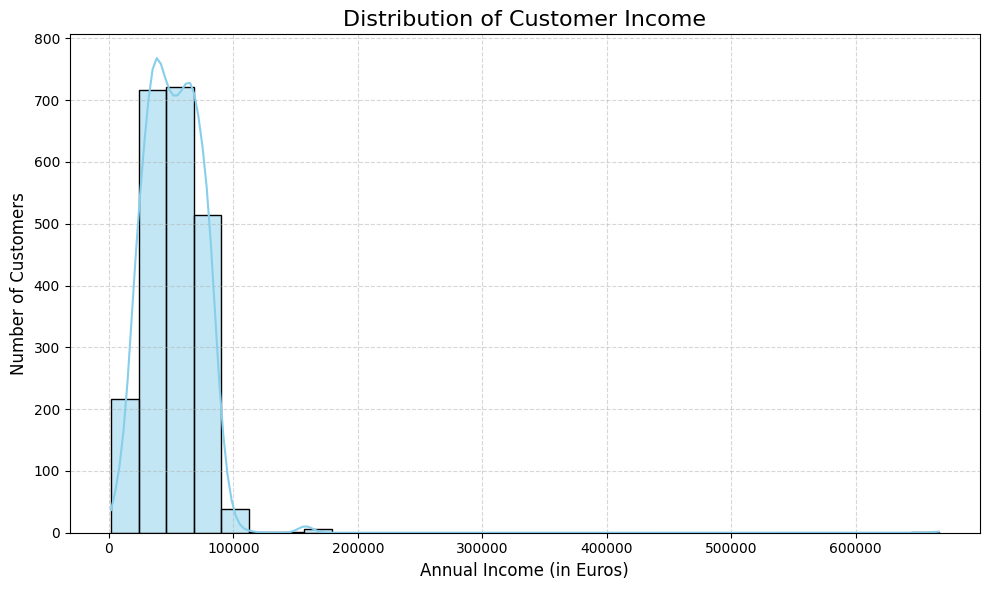

In [31]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Income'], bins=30, kde=True, color='skyblue', edgecolor='black')

# visual enhancements
plt.title('Distribution of Customer Income', fontsize=16)
plt.xlabel('Annual Income (in Euros)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Boxplot

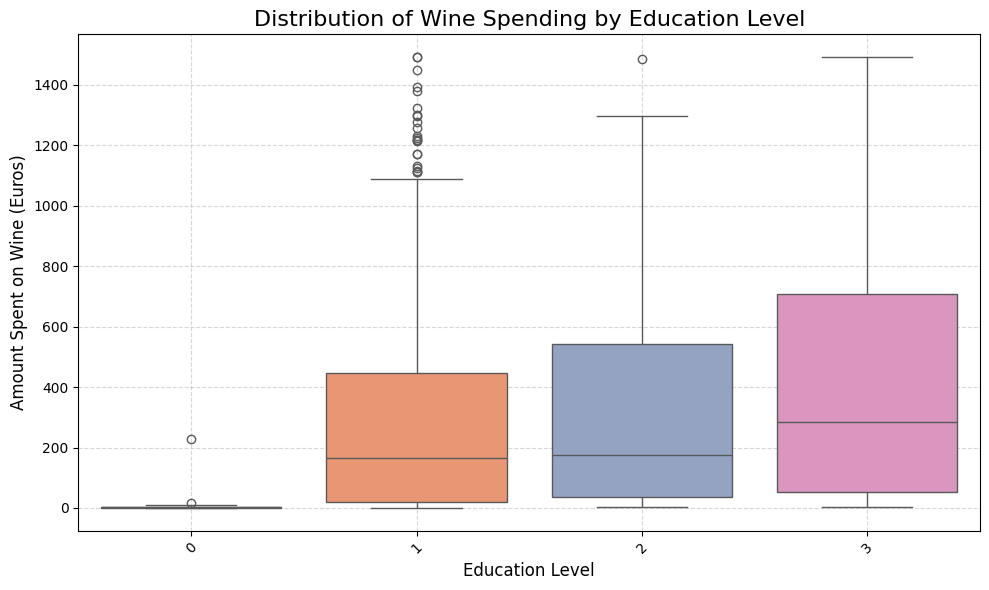

In [32]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Education', y='MntWines', data=df, palette='Set2')

# Visual enhancements
plt.title('Distribution of Wine Spending by Education Level', fontsize=16)
plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Amount Spent on Wine (Euros)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Correlation Heatmap

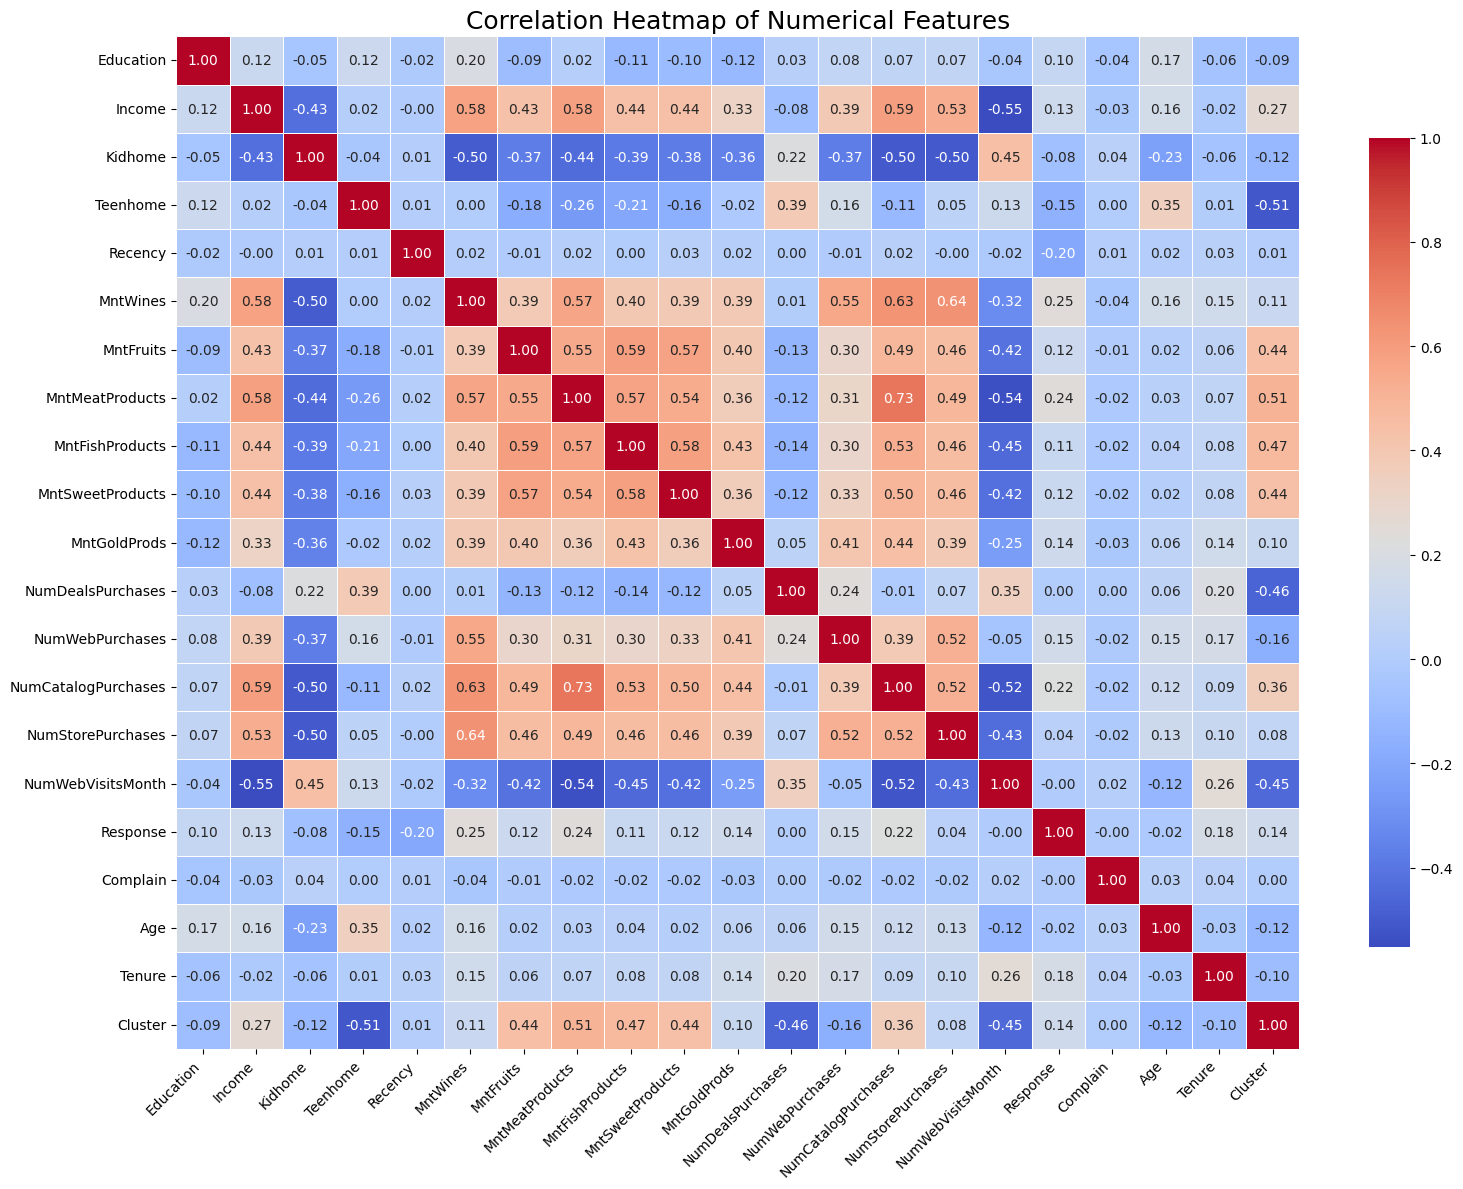

In [33]:
# Correlation heatmap
plt.figure(figsize=(16, 12))
correlation_matrix = df.select_dtypes(include='number').corr()

sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            linewidths=0.5,
            linecolor='white',
            cbar_kws={"shrink": .8})

# Add title and formatting
plt.title("Correlation Heatmap of Numerical Features", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Clustering

In [8]:
# Clustering
X_cluster = df[numeric_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

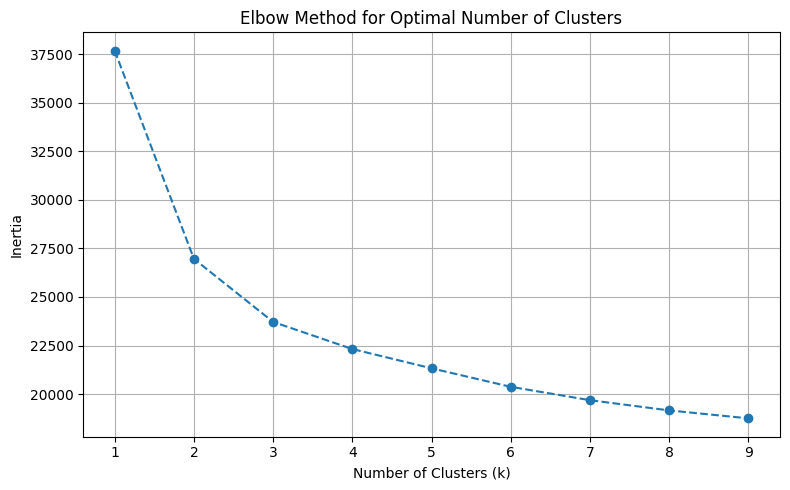

In [10]:
# Elbow Plot
def plot_elbow(X, save_path='elbow_plot.png'):
    X_scaled = StandardScaler().fit_transform(X[numeric_features])
    inertia = []
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 10), inertia, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_elbow(X_cluster)

# Scatter Plot

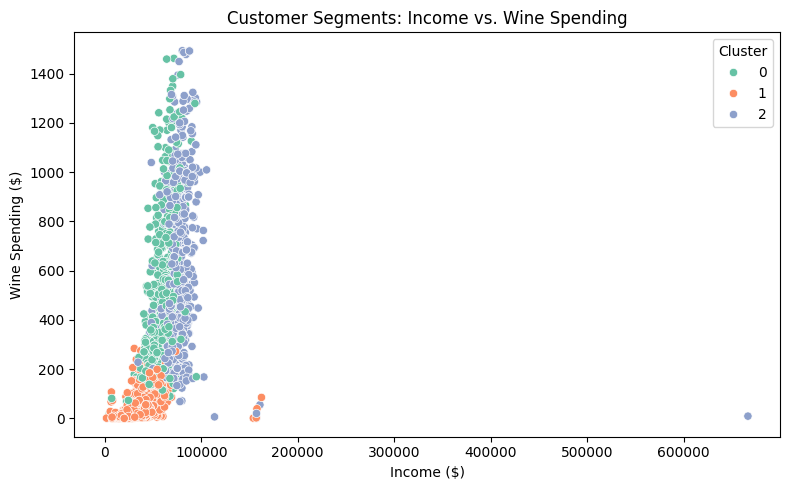

In [11]:
# Scatter Plot
def plot_scatter(X, clusters, save_path='scatter_plot.png'):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='Income', y='MntWines', hue=clusters, palette='Set2', data=X)
    plt.title('Customer Segments: Income vs. Wine Spending')
    plt.xlabel('Income ($)')
    plt.ylabel('Wine Spending ($)')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

plot_scatter(X_cluster, df['Cluster'])

# Silhouette Score

In [29]:
# Silhouette Score
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    print(f"Silhouette Score for k={k}: {score:.2f}")

Silhouette Score for k=2: 0.28
Silhouette Score for k=3: 0.22
Silhouette Score for k=4: 0.20
Silhouette Score for k=5: 0.14


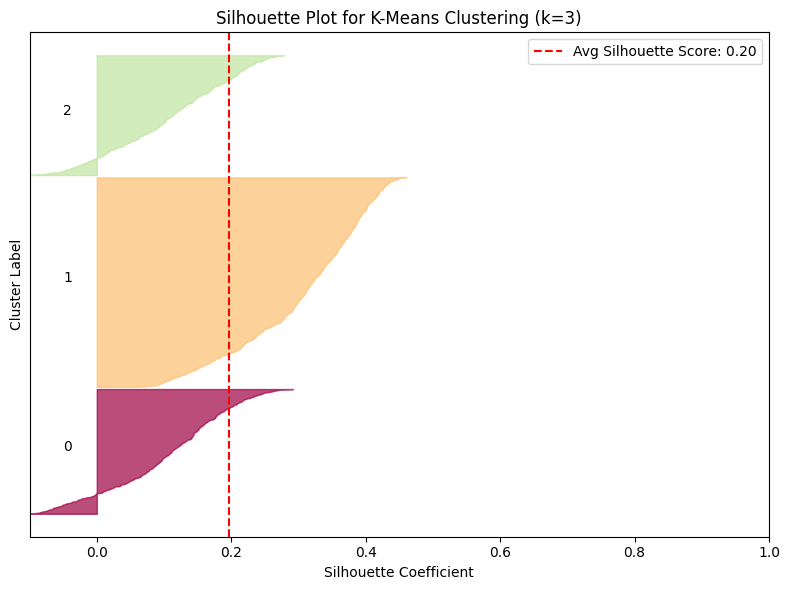

In [12]:
# Silhouette Plot
def plot_silhouette(X, n_clusters=3, save_path='silhouette_plot.png'):
    X_processed = preprocessor.fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_processed)
    silhouette_avg = silhouette_score(X_processed, cluster_labels)
    sample_silhouette_values = silhouette_samples(X_processed, cluster_labels)

    fig, ax = plt.subplots(figsize=(8, 6))
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.Spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_title(f'Silhouette Plot for K-Means Clustering (k={n_clusters})')
    ax.set_xlabel('Silhouette Coefficient')
    ax.set_ylabel('Cluster Label')
    ax.axvline(x=silhouette_avg, color='red', linestyle='--', label=f'Avg Silhouette Score: {silhouette_avg:.2f}')
    ax.legend()
    ax.set_yticks([])
    ax.set_xlim([-0.1, 1])
    plt.tight_layout()
    plt.show()

plot_silhouette(X, n_clusters=3)

# Fitting

In [13]:
# Fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_balanced, y_train_balanced)
y_pred = log_reg.predict(X_test_processed)

print("\nLogistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Logistic Regression Results:
Accuracy: 0.7879699248120301
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.79      0.86       565
           1       0.40      0.78      0.53       100

    accuracy                           0.79       665
   macro avg       0.67      0.78      0.69       665
weighted avg       0.87      0.79      0.81       665



# Pie Chart

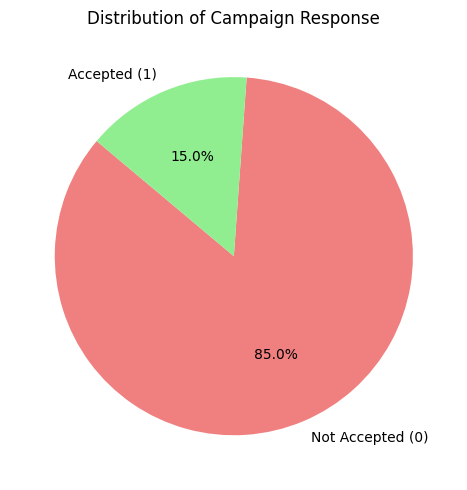

In [14]:
# Pie Chart
def plot_pie(y, save_path='pie_chart.png'):
    response_counts = y.value_counts()
    plt.figure(figsize=(5, 5))
    plt.pie(response_counts, labels=['Not Accepted (0)', 'Accepted (1)'], autopct='%1.1f%%',
            startangle=140, colors=['lightcoral', 'lightgreen'])
    plt.title('Distribution of Campaign Response')
    plt.tight_layout()
    plt.show()

plot_pie(y)

# Confusion Matrix

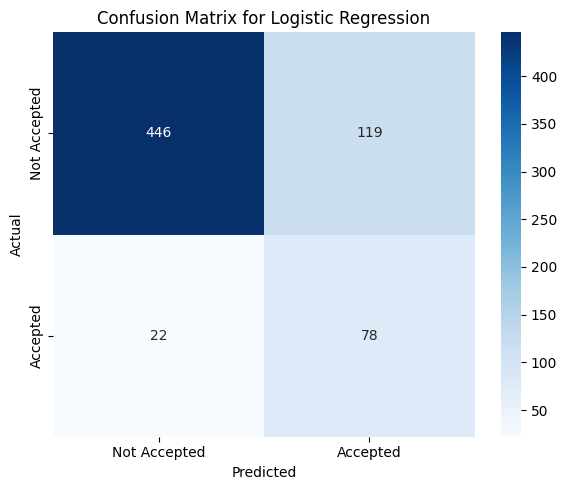

In [15]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, save_path='confusion_matrix.png'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Accepted', 'Accepted'],
                yticklabels=['Not Accepted', 'Accepted'])
    plt.title('Confusion Matrix for Logistic Regression')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


plot_confusion_matrix(y_test, y_pred)

# ROC Curve

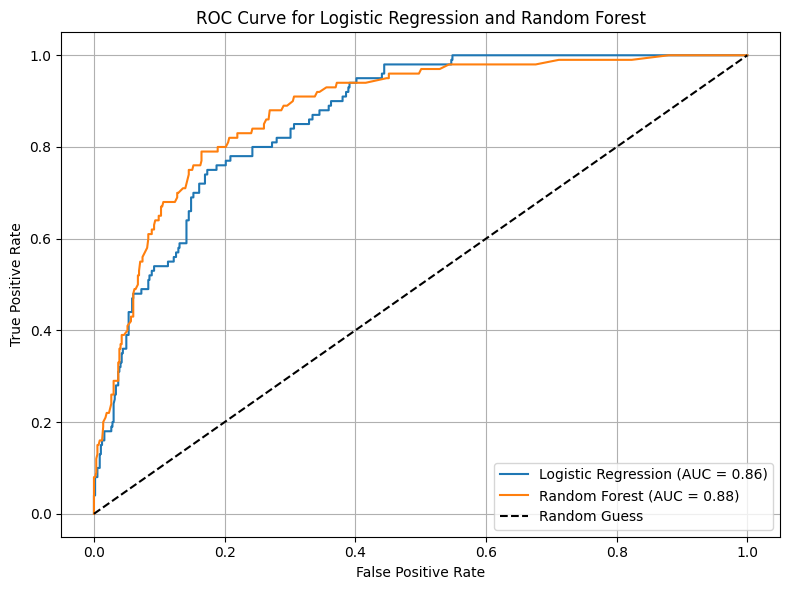

In [16]:
# ROC Curve
def plot_roc_curve(X, y, save_path='roc_curve.png'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Apply SMOTE to training data
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

    log_reg = LogisticRegression(random_state=42, max_iter=1000)
    rf = RandomForestClassifier(random_state=42)

    log_reg.fit(X_train_balanced, y_train_balanced)
    rf.fit(X_train_balanced, y_train_balanced)

    log_reg_probs = log_reg.predict_proba(X_test_processed)[:, 1]
    rf_probs = rf.predict_proba(X_test_processed)[:, 1]

    log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_probs)
    rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
    log_reg_auc = auc(log_reg_fpr, log_reg_tpr)
    rf_auc = auc(rf_fpr, rf_tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {log_reg_auc:.2f})')
    plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title('ROC Curve for Logistic Regression and Random Forest')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_roc_curve(X, y)

# Feature Importance Plot

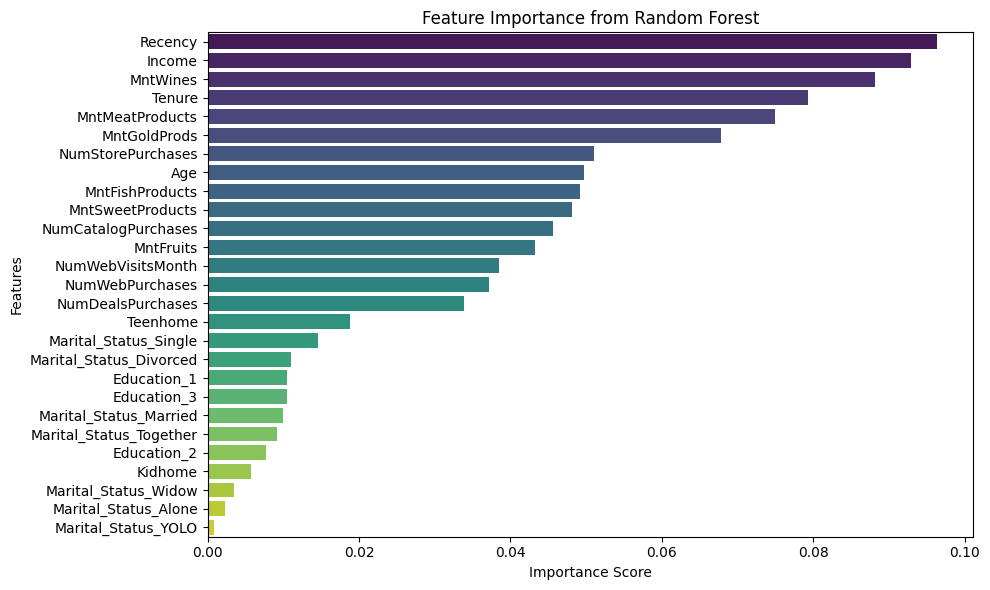

In [17]:
# Feature Importance Plot
def plot_feature_importance(X, y, save_path='feature_importance_plot.png'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_train_processed = preprocessor.fit_transform(X_train)

    num_features = numeric_features
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    feature_names = np.concatenate([num_features, cat_features])

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_processed, y_train)

    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=feature_names[indices], palette='viridis')
    plt.title('Feature Importance from Random Forest')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

plot_feature_importance(X, y)